# What is GAN (Generative Adversarial Network)?


* GAN is basically a way of training a generative model using a supervised learning problem.
* There are 2 basic requirements namely, Generator : Model used to generate plausible or fake samples from already available samples and discriminator : Model used to classify the given samples as real or fake.
* The two models are trained together in a zero-sum game until the discriminator is fooled about half the time.
* A single training cycle involves first selecting a batch of real images from the problem domain. A batch of latent points is generated and fed to the generator model to synthesize a batch of images. The discriminator is then updated using the batch of real and generated images, minimizing binary cross-entropy loss used in any binary classification problem.The generator is then updated via the discriminator model. This means that generated images are presented to the discriminator as though they are real (not generated) and the error is propagated back through the generator model. This has the effect of updating the generator model toward generating images that are more likely to fool the discriminator.
	
![](https://miro.medium.com/max/1800/1*TKr1dtcNgJCA8uYY1OhmSg.png)

This is a basic implementation of Generative Adversarial Network to generate fake images of cats. I am a complete beginner in GANs so feel free to correct/suggest topics.


Code referred from [this post](https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5)

## &#10148; Import

In [18]:
# import
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path

#--------------------------------------------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

#--------------------------------------------------#
import cv2

#--------------------------------------------------#
from tqdm.notebook import tqdm

#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#--------------------------------------------------#
%matplotlib inline




## &#10148; Load Dataset

In [19]:
dir = './input/celeba'
print(os.listdir(dir)[:20])

image_size = 64
batch_size = 512
stats      = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform = tt.Compose([ tt.Resize    (image_size) ,
                                                     tt.CenterCrop(image_size) ,
                                                     tt.ToTensor  ()           ,
                                                     tt.Normalize (*stats)     , ])
                       )  

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg']


## &#10148; Define functions for showing the images

In [20]:

def denorm(img_tensors):
    print(stats)
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[ : nmax ]), nrow = 6).permute(1, 2, 0))

def show_batch(dl, nmax = 64):
    for images, _ in dl:
        show_images(images, nmax)
        break



## &#10148; Load data into device with CPU/GPU compatibility

In [21]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = is_cuda_available()

train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


## &#10148; Define Discriminator

In [22]:
#basic cnn with convolutional layers and leaky relu as activation fn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

## &#10148; Define Generator

In [23]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
#show_images(fake_images)

generator = to_device(generator, device)



torch.Size([512, 3, 64, 64])


## &#10148; Function To Train Discriminator

In [24]:
def train_discriminator(real_images, opt_d, epoch_num = 0, if_save = False ):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    


    return loss.item(), real_score, fake_score

## &#10148; Function To Train Generator

In [25]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [26]:

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 6)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 6).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(36, latent_size, 1, 1, device = device)

In [29]:
save_samples(0, fixed_latent, show = False)

print()

((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0000.png



In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
    
    for epoch in range(epochs):
        for idx, (real_images, _) in enumerate(tqdm(train_dl)):
            if idx == 0:
                print("First Image of this Epoch, Save a temp Model.")
                if_save = True
            else:
                if_save = False
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d, epoch_num = epoch, if_save = if_save)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch + start_idx, fixed_latent, show = False)
        torch.save(generator.state_dict(), 'Saving_folder/generator_celeba_' + str(epoch) + '.pt')

    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0003
epochs = 65

In [32]:
losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)

  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [1/65], loss_g: 5.2107, loss_d: 0.8624, real_score: 0.9260, fake_score: 0.4761
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0001.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [2/65], loss_g: 2.3434, loss_d: 0.6586, real_score: 0.6721, fake_score: 0.1718
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0002.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [3/65], loss_g: 4.1203, loss_d: 0.9303, real_score: 0.8350, fake_score: 0.4947
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0003.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [4/65], loss_g: 0.5999, loss_d: 1.9091, real_score: 0.1932, fake_score: 0.0094
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0004.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [5/65], loss_g: 4.3260, loss_d: 0.3597, real_score: 0.9449, fake_score: 0.2469
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0005.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [6/65], loss_g: 4.4489, loss_d: 0.3083, real_score: 0.9163, fake_score: 0.1862
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0006.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [7/65], loss_g: 2.4753, loss_d: 0.3934, real_score: 0.7253, fake_score: 0.0303
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0007.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [8/65], loss_g: 3.1572, loss_d: 0.2034, real_score: 0.8781, fake_score: 0.0601
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0008.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [9/65], loss_g: 3.4441, loss_d: 0.1809, real_score: 0.9244, fake_score: 0.0914
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0009.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [10/65], loss_g: 3.3689, loss_d: 0.1180, real_score: 0.9566, fake_score: 0.0672
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0010.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [11/65], loss_g: 8.1018, loss_d: 1.4397, real_score: 0.9936, fake_score: 0.7061
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0011.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [12/65], loss_g: 2.1585, loss_d: 0.3589, real_score: 0.7495, fake_score: 0.0271
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0012.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [13/65], loss_g: 3.3037, loss_d: 0.3912, real_score: 0.8575, fake_score: 0.1829
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0013.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [14/65], loss_g: 3.0365, loss_d: 0.4245, real_score: 0.7120, fake_score: 0.0331
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0014.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [15/65], loss_g: 3.5128, loss_d: 0.1847, real_score: 0.9035, fake_score: 0.0707
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0015.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [16/65], loss_g: 7.6401, loss_d: 0.7491, real_score: 0.9815, fake_score: 0.4635
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0016.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [17/65], loss_g: 3.0544, loss_d: 0.2316, real_score: 0.8753, fake_score: 0.0787
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0017.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [18/65], loss_g: 4.8083, loss_d: 0.1491, real_score: 0.9172, fake_score: 0.0548
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0018.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [19/65], loss_g: 3.5790, loss_d: 0.1661, real_score: 0.8718, fake_score: 0.0196
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0019.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [20/65], loss_g: 3.0683, loss_d: 0.9273, real_score: 0.4677, fake_score: 0.0036
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0020.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [21/65], loss_g: 4.0513, loss_d: 0.0592, real_score: 0.9714, fake_score: 0.0280
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0021.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [22/65], loss_g: 3.8483, loss_d: 0.3910, real_score: 0.9743, fake_score: 0.2791
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0022.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [23/65], loss_g: 5.7092, loss_d: 0.0471, real_score: 0.9580, fake_score: 0.0030
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0023.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [24/65], loss_g: 5.1393, loss_d: 0.0921, real_score: 0.9238, fake_score: 0.0089
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0024.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [25/65], loss_g: 4.7642, loss_d: 0.0878, real_score: 0.9836, fake_score: 0.0654
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0025.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [26/65], loss_g: 3.8809, loss_d: 0.2575, real_score: 0.8690, fake_score: 0.0880
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0026.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [27/65], loss_g: 4.2357, loss_d: 0.1335, real_score: 0.9722, fake_score: 0.0938
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0027.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [28/65], loss_g: 2.8892, loss_d: 0.3583, real_score: 0.7888, fake_score: 0.0779
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0028.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [29/65], loss_g: 2.6077, loss_d: 0.4827, real_score: 0.6793, fake_score: 0.0133
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0029.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [30/65], loss_g: 3.4018, loss_d: 0.2388, real_score: 0.8212, fake_score: 0.0213
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0030.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [31/65], loss_g: 2.7214, loss_d: 0.0762, real_score: 0.9505, fake_score: 0.0225
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0031.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [32/65], loss_g: 4.8803, loss_d: 0.1360, real_score: 0.9777, fake_score: 0.1002
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0032.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [33/65], loss_g: 4.6102, loss_d: 0.0928, real_score: 0.9427, fake_score: 0.0285
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0033.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [34/65], loss_g: 3.2605, loss_d: 0.0884, real_score: 0.9727, fake_score: 0.0565
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0034.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [35/65], loss_g: 5.5583, loss_d: 0.2530, real_score: 0.8146, fake_score: 0.0164
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0035.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [36/65], loss_g: 4.1969, loss_d: 0.0725, real_score: 0.9751, fake_score: 0.0437
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0036.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [37/65], loss_g: 3.4637, loss_d: 0.2301, real_score: 0.9108, fake_score: 0.1070
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0037.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [38/65], loss_g: 1.1692, loss_d: 0.7304, real_score: 0.5630, fake_score: 0.0208
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0038.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [39/65], loss_g: 3.3838, loss_d: 0.4113, real_score: 0.7080, fake_score: 0.0187
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0039.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [40/65], loss_g: 3.1736, loss_d: 0.2633, real_score: 0.9173, fake_score: 0.1444
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0040.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [41/65], loss_g: 3.6412, loss_d: 0.1186, real_score: 0.9498, fake_score: 0.0592
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0041.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [42/65], loss_g: 4.3408, loss_d: 0.1178, real_score: 0.9470, fake_score: 0.0561
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0042.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [43/65], loss_g: 4.2836, loss_d: 0.3646, real_score: 0.8393, fake_score: 0.1353
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0043.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [44/65], loss_g: 4.2763, loss_d: 0.1592, real_score: 0.8788, fake_score: 0.0193
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0044.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [45/65], loss_g: 6.9179, loss_d: 9.5501, real_score: 0.9997, fake_score: 0.9983
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0045.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [46/65], loss_g: 4.3464, loss_d: 0.1747, real_score: 0.9685, fake_score: 0.1233
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0046.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [47/65], loss_g: 2.0576, loss_d: 0.9028, real_score: 0.4879, fake_score: 0.0067
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0047.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [48/65], loss_g: 3.9674, loss_d: 0.0669, real_score: 0.9704, fake_score: 0.0342
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0048.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [49/65], loss_g: 4.1044, loss_d: 0.2131, real_score: 0.9599, fake_score: 0.1376
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0049.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [50/65], loss_g: 4.9826, loss_d: 0.0361, real_score: 0.9822, fake_score: 0.0173
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0050.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [51/65], loss_g: 4.3900, loss_d: 0.4694, real_score: 0.9182, fake_score: 0.2642
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0051.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [52/65], loss_g: 7.2177, loss_d: 3.8170, real_score: 0.9984, fake_score: 0.9421
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0052.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [53/65], loss_g: 3.9354, loss_d: 0.1047, real_score: 0.9573, fake_score: 0.0549
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0053.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [54/65], loss_g: 3.6451, loss_d: 0.1480, real_score: 0.9213, fake_score: 0.0546
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0054.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [55/65], loss_g: 3.6699, loss_d: 0.1498, real_score: 0.9091, fake_score: 0.0422
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0055.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [56/65], loss_g: 4.6784, loss_d: 0.1059, real_score: 0.9512, fake_score: 0.0484
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0056.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [57/65], loss_g: 6.1605, loss_d: 0.3766, real_score: 0.9887, fake_score: 0.2578
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0057.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [58/65], loss_g: 4.8921, loss_d: 0.4304, real_score: 0.9464, fake_score: 0.2580
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0058.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [59/65], loss_g: 3.0578, loss_d: 0.2578, real_score: 0.8500, fake_score: 0.0692
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0059.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [60/65], loss_g: 4.1631, loss_d: 0.0713, real_score: 0.9646, fake_score: 0.0318
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0060.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [61/65], loss_g: 2.1812, loss_d: 0.5601, real_score: 0.7377, fake_score: 0.1448
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0061.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [62/65], loss_g: 3.8088, loss_d: 0.0945, real_score: 0.9369, fake_score: 0.0230
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0062.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [63/65], loss_g: 2.8887, loss_d: 0.3890, real_score: 0.8163, fake_score: 0.1290
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0063.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [64/65], loss_g: 4.2012, loss_d: 1.2660, real_score: 0.9168, fake_score: 0.5877
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0064.png


  0%|          | 0/396 [00:00<?, ?it/s]

First Image of this Epoch, Save a temp Model.
Epoch [65/65], loss_g: 5.3558, loss_d: 0.0805, real_score: 0.9505, fake_score: 0.0230
((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0065.png


In [40]:

print(losses_d   )
print(losses_g   )
print(fake_scores)
print(real_scores)

[0.8624257445335388, 0.6585837602615356, 0.9303159713745117, 1.9091037511825562, 0.35974422097206116, 0.3082663416862488, 0.39341869950294495, 0.20340731739997864, 0.1808529496192932, 0.11798013746738434, 1.439685344696045, 0.358904093503952, 0.39117011427879333, 0.4245178997516632, 0.18465809524059296, 0.7490733861923218, 0.2315714955329895, 0.14910346269607544, 0.166117861866951, 0.9272521138191223, 0.059219714254140854, 0.3909868597984314, 0.047063011676073074, 0.09208539873361588, 0.08781896531581879, 0.25748711824417114, 0.13345858454704285, 0.35830432176589966, 0.4827316403388977, 0.23878949880599976, 0.07622148096561432, 0.13602645695209503, 0.09281496703624725, 0.08837823569774628, 0.25301501154899597, 0.07246463000774384, 0.2301490157842636, 0.7303503751754761, 0.4112805128097534, 0.2632877826690674, 0.11860482394695282, 0.11775270104408264, 0.36460262537002563, 0.15920372307300568, 9.550105094909668, 0.17465060949325562, 0.9028238654136658, 0.0668950229883194, 0.2131200134754

In [41]:
from IPython.display import Image

One Fake generated image:

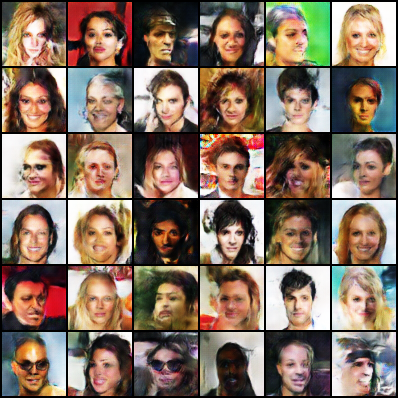

In [42]:
Image('./generated/generated-images-0033.png')

In [43]:

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, ( (image_size * 6 + 2 * (6+1) ) , (image_size * 6 + 2 * (6+1) )))
[out.write(cv2.imread(fname)) for fname in files]
out.release()



Text(0.5, 1.0, 'Losses')

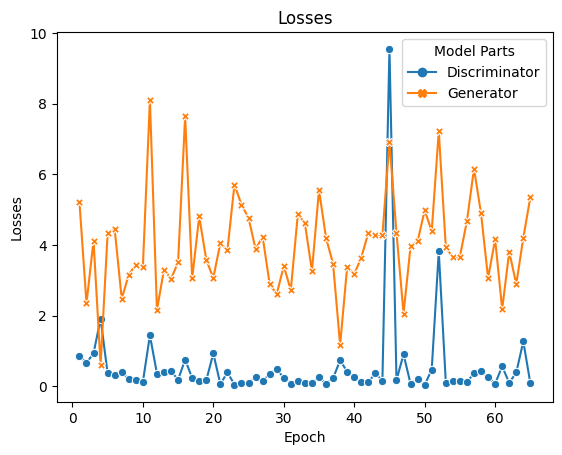

In [44]:
# Create a DF for plotting the losses.
losses_list = losses_d + losses_g
hue_list    = ["Discriminator"] * len(losses_d) + ["Generator"] * len(losses_g)
epoch_list  = [i+1 for i in range(len(losses_d))] + [i+1 for i in range(len(losses_d))] 

import pandas as pd
df_losses = pd.DataFrame({'Losses' : losses_list , 'Model Parts' : hue_list, 'Epoch' : epoch_list})


sns.lineplot(
    data = df_losses,
    x = "Epoch", y = "Losses", hue = "Model Parts", style = "Model Parts",
    markers=True, dashes=False
)

plt.title('Losses')

Text(0.5, 1.0, 'Scores')

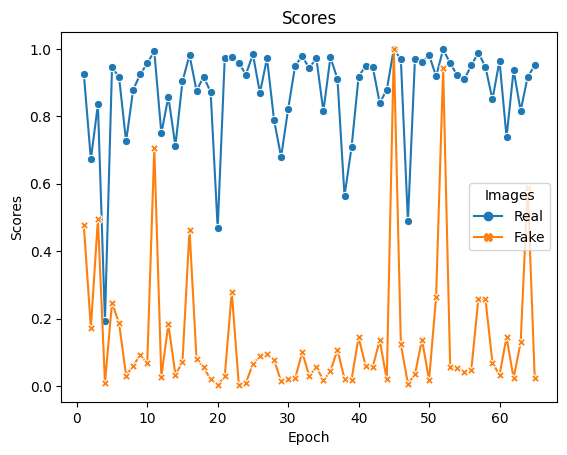

In [45]:


# Create a DF for plotting the losses.
scores_list = real_scores + fake_scores
hue_list    = ["Real"] * len(real_scores) + ["Fake"] * len(fake_scores)
epoch_list  = [i+1 for i in range(len(real_scores))] + [i+1 for i in range(len(fake_scores))] 

df_scores = pd.DataFrame({'Scores' : scores_list , 'Images' : hue_list, 'Epoch' : epoch_list})


sns.lineplot(
    data = df_scores,
    x = "Epoch", y = "Scores", hue = "Images", style = "Images",
    markers=True, dashes=False
)

plt.title('Scores')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
Saving generated-images-0000.png


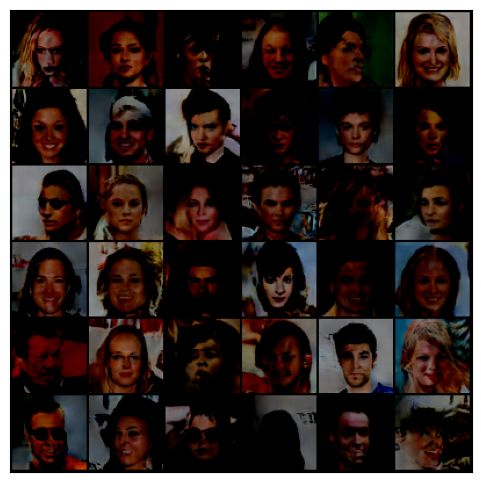

In [39]:
save_samples(0, fixed_latent)